# Skin Cancer Binary Classification CNN HOTARU v1.3

The following notebook displays how the third version of the CNN model for skin cancer identification HOTARU was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

This model is one half of the identification program. HOTARU v1.3 is accompanied by SPARK v1.15, the third version of the accompanying image preprocessing script, which features some fine tuning.

This model consists of a CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

## Changes done
- Attempted to improve performance by augmenting non-skin-cancer image data to defeat data disparity.
- Attempted to improve performance by taking inspiration from the VGG16 architecture to build a new structure to the model.
- Increased epochs from 10 to 20 after being able to utilise GPU for processing.

## Preparation - importing, GPU setup, dataset setup

In [1]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage import io, color, exposure
from skimage.filters import threshold_otsu

In [2]:
# Confirming GPU is available for use
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Defining datasets, which are already preprocessed prior to feeding to model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/test', image_size=(300,300), batch_size=32)

Found 62050 files belonging to 2 classes.
Found 7756 files belonging to 2 classes.
Found 7758 files belonging to 2 classes.


# Creating model

In [5]:
# Creating Sequential object
cnn = Sequential()

In [6]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(3,3)))
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(3,3)))        
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(3,3)))  
cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(3,3))) 
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [7]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [8]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 16)      2320      
                                                                 
 dropout (Dropout)           (None, 300, 300, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      9248      
                                                        

# Logging

In [9]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [10]:
hist = cnn.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/20
1940/1940 [==============================] - 500s 252ms/step - loss: 0.3220 - accuracy: 0.8681 - precision: 0.8987 - recall: 0.8285 - val_loss: 0.2709 - val_accuracy: 0.8935 - val_precision: 0.9513 - val_recall: 0.8286
Epoch 2/20
1940/1940 [==============================] - 151s 78ms/step - loss: 0.2372 - accuracy: 0.9025 - precision: 0.9267 - recall: 0.8732 - val_loss: 0.2253 - val_accuracy: 0.9029 - val_precision: 0.9182 - val_recall: 0.8838
Epoch 3/20
1940/1940 [==============================] - 244s 126ms/step - loss: 0.2164 - accuracy: 0.9113 - precision: 0.9298 - recall: 0.8891 - val_loss: 0.2093 - val_accuracy: 0.9100 - val_precision: 0.9424 - val_recall: 0.8726
Epoch 4/20
1940/1940 [==============================] - 350s 179ms/step - loss: 0.2013 - accuracy: 0.9185 - precision: 0.9341 - recall: 0.8999 - val_loss: 0.2287 - val_accuracy: 0.9056 - val_precision: 0.9603 - val_recall: 0.8455
Epoch 5/20
1940/1940 [==============================] - 154s 79ms/step - loss: 0.

# Evaluation - Loss, Accuracy, Precision, Recall and F1-Score

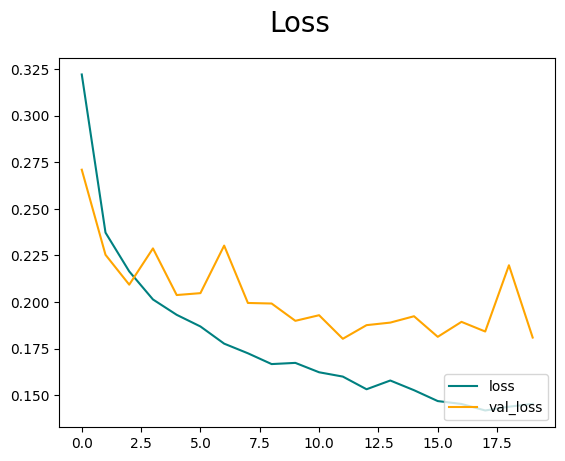

In [11]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="lower right")
plt.show()

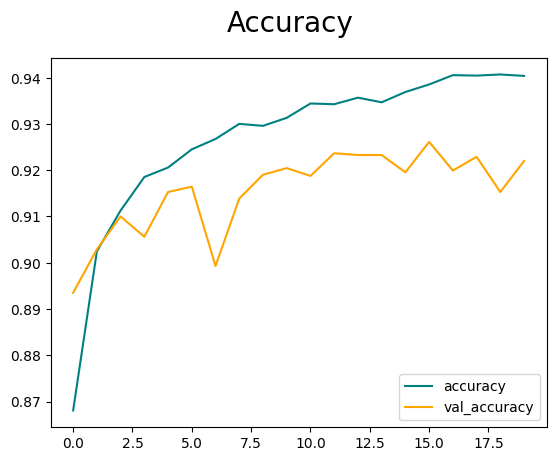

In [12]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

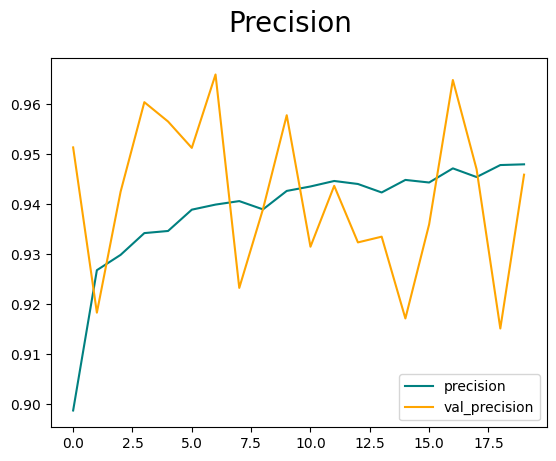

In [13]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='precision')
plt.plot(hist.history['val_precision'], color='orange', label='val_precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="lower right")
plt.show()

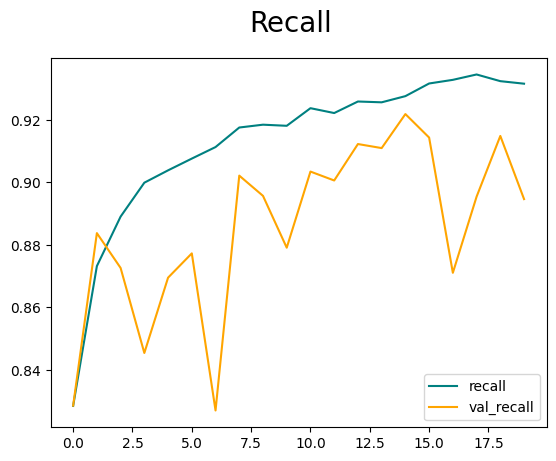

In [14]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
plt.plot(hist.history['val_recall'], color='orange', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [15]:
# Calculating F1-score for every epoch

f1_score = []

for i in range(len(hist.history['precision'])):
    x = 2 * ((hist.history['precision'][i] * hist.history['recall'][i]) / (hist.history['precision'][i] + hist.history['recall'][i]))
    f1_score.append(x)

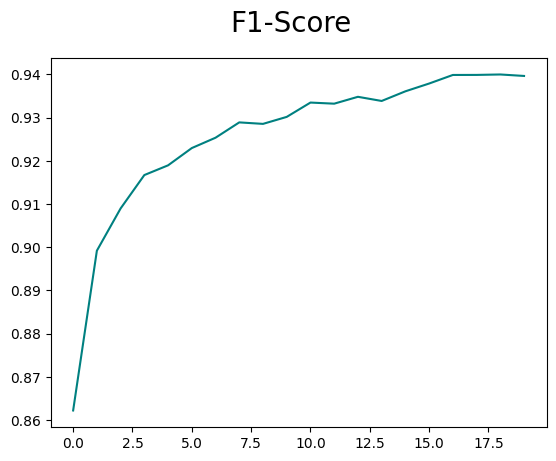

In [16]:
fig = plt.figure()
plt.plot(f1_score, color='teal', label='f1-score')
fig.suptitle('F1-Score', fontsize=20)
plt.show()

# Testing with a batch

In [17]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy, model_precision, model_recall = cnn.evaluate(test_dataset,verbose=1)

# Calculating F1-score manually
f1score = 2 * ((model_precision * model_recall) / (model_precision + model_recall))

# Printing metrics
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}, F1-score: {f1score}")

243/243 [==============================] - 14s 50ms/step - loss: 0.1703 - accuracy: 0.9283 - precision: 0.9509 - recall: 0.9027
Loss: 0.17034180462360382, Accuracy: 0.9283320307731628, Precision: 0.9509269595146179, Recall: 0.9026914834976196, F1-score: 0.926181621701165


243/243 [==============================] - 8s 32ms/step
 
Confusion matrix:
---------------------


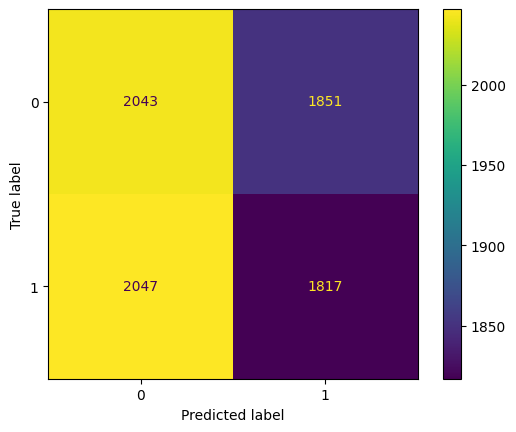

---------------------
False positive rate: 0.47534668721109397
False negative rate: 0.5297619047619048
---------------------
Classification Report:
---------------------
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      3894
           1       0.50      0.47      0.48      3864

    accuracy                           0.50      7758
   macro avg       0.50      0.50      0.50      7758
weighted avg       0.50      0.50      0.50      7758



In [18]:
# Creating confusion matrix and classification report

# Creating ground truth label list
classes = test_dataset.class_names 
y_true = []

for images, label in test_dataset:   
    for e in label:
        y_true.append(int(classes[e]))

# Creating prediction list
y_pred = cnn.predict(test_dataset)
y_pred = np.round(y_pred).tolist()

# Converting all lists gathered to arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

tn, fp, fn, tp = cm.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)

print(" ")
print("Confusion matrix:") 
print("---------------------")
disp.plot()
plt.show()
print("---------------------")
print(f"False positive rate: {false_positive_rate}")
print(f"False negative rate: {false_negative_rate}")
print("---------------------")

# Generating classification report
clr = classification_report(y_true, y_pred, target_names=classes)

print("Classification Report:") 
print("---------------------")
print(clr)

**Result**

Accuracy of 50-92.8%, with precision of 95.1%, recall of 90.3% and F1-score of 92.6%.

When comparing HOTARU v1.3 with v1.2, v1.3 had slightly better accuracy and precision than v1.2, but suffered greatly in recall, resulting in a lower F1-score than v1.2. In addition, it seemed that with the new dataset, the model had a 50:50 chance of making a false result, as seen by the distribution in the confusion matrix and the false positive and negative rates.

At this point, despite multiple attempts to improve performance, those attempts proved to be fruitless when using a binary classification framework to assess its performance. Therefore, it is now suggested that instead of using a skin-cancer/not-skin-cancer result, a confidence level is to be provided to the enduser. As seen later, the output of the model provides a value between 0.00 and 1.00, which can be easily altered to a percentage which the enduser can then use to make their own decision.

# Testing with a single picture / Showcasing SPARK script

In [19]:
# Creating preprocessing function
def prepro(img_path, cmap_type='gray'):
    # Loading in image
    img = Image.open(img_path)
    
    '''
    Section 1: Translating image into array
    '''
    # Resize the image to a consistent size (e.g., 224x224)
    img = img.resize((300, 300))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Create original image variable for comparison - this is not in image_preprocessing.py
    img_ori = img_array
    
    # Normalize pixel values
    img_array = cv2.normalize(img_array, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

    '''
    Section 2: Creating the mask to remove unnecessary features like healthy skin and hair.
    Hair is first removed with the DullRazor algorithm, resulting in an image which is then used
    to create a mask highlighting the skinmark.
    '''
    # Converting RGB picture to greyscale for hair removal
    img_gc = color.rgb2gray(img_array)

    # Enhance contrast
    img_gc = exposure.adjust_gamma(img_gc, gamma=2.5)

    #DullRazor algorithm starts here
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(5,5)) 
    blackhat = cv2.morphologyEx(img_gc, cv2.MORPH_BLACKHAT, kernel)
    
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    #Masking hair
    ret, mask = cv2.threshold(bhg,0.02,255,cv2.THRESH_BINARY)
    
    # Normalise mask
    mask = cv2.normalize(mask, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    
    #Replace pixels in img_array covered in mask to create image without hair
    dst = cv2.inpaint(img_array, mask, 6, cv2.INPAINT_TELEA)
    #DullRazor algorithm ends here

    # Segmentation preparation
    # Adjusting exposure
    img_ex = exposure.adjust_log(dst)

    # Apply gamma correction
    gamma = 1.5 # You can experiment with different gamma values
    img_gamma_corrected = exposure.adjust_gamma(img_ex, gamma=gamma)

    # Converting cleaned photo into greyscale for thresholding/segmentation
    img_gt = color.rgb2gray(img_gamma_corrected)

    # Global thresholding with Otsu
    thresh = threshold_otsu(img_gt)
    
    # Creating threshold image
    img_t = img_gt <= thresh

    # Creating mask using threshold image
    # Value 0 as black and white photo used
    mask = np.where(img_t >= 0, img_t, 0)

    '''
    Section 3: Creating the final processed photo by only including parts of img_array that is highlighted by the mask.
    '''
    # Nested for loop for each 'row' of img
    for h in range(mask.shape[0]):
      # For each 'column' of img
        for w in range(mask.shape[1]):
          # If the pixel chosen from the mask is white, add in the pixel from the original image
          # Otherwise, discard/make pixel black
            if mask[h][w] == 0:
                for i in range(3):
                    img_array[h][w][i] = 0
            else:
                continue

    # Show original and preprocessed photo side by side
    plt.subplot(1, 2, 1)
    plt.imshow(img_ori, cmap=cmap_type)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap=cmap_type)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_array

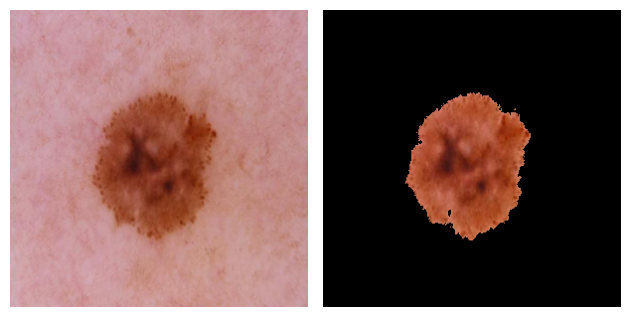

In [20]:
# Feeding model with a photo with a ground truth of having skin cancer

# Preprocessing image
img1 = prepro("img_data/test/1/ISIC_0028033.jpg")

In [21]:
# Model prediction
pred1 = cnn.predict(np.expand_dims(img1/255, 0))

if pred1 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred1

1/1 [==============================] - 0s 214ms/step
Skin cancer not detected


array([[0.46160454]], dtype=float32)

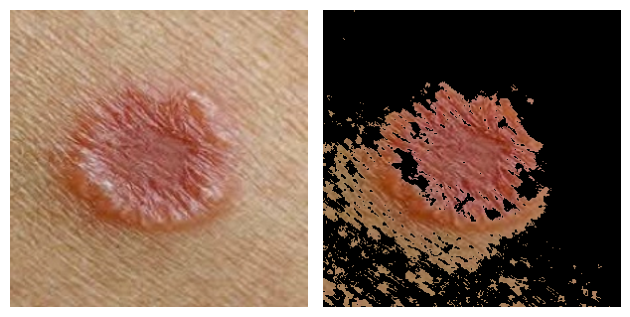

In [22]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Preprocessing image
img2 = prepro("img_data/test/0/79_FU-ringworm (33).jpg")

In [23]:
# Model prediction
pred2 = cnn.predict(np.expand_dims(img2/255, 0))

if pred2 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred2

1/1 [==============================] - 0s 18ms/step
Skin cancer detected


array([[0.56028205]], dtype=float32)

**Results**

Correctly identified skin cancer image, but did not correctly identify non-skin cancer image.

## Saving the model

In [24]:
# Export our model to HDF5 file
cnn.save("models/prod_6.h5")

In [25]:
# Exporting model as Pickle file
import pickle

pickle.dump(cnn, open('models/prod_6.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ad14acbf-bfe1-48b0-b06e-7d0afd3ee00a/assets


INFO:tensorflow:Assets written to: ram://ad14acbf-bfe1-48b0-b06e-7d0afd3ee00a/assets
